In [64]:
#!pip3 install geopandas

In [65]:
import numpy as np
import os
import pandas as pd
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import random
from shapely.affinity import translate
from shapely.geometry import LineString, Point
from shapely.ops import split
from geopy.distance import distance as geodesic_distance


class City:
    def __init__(self, name: str, geo_lat: float, geo_lon: float):
        self.name = name
        self.geo_lat = geo_lat
        self.geo_lon = geo_lon

    def __str__(self):
        return self.name

    def get_coordinates_lat_lon(self):
        return self.geo_lat, self.geo_lon

    def get_coordinates_lon_lat(self):
        return self.geo_lon, self.geo_lat

    def distance_to(self, city):
        distance = geodesic_distance(self.get_coordinates_lat_lon(), city.get_coordinates_lat_lon())
        return distance.km


In [66]:
def loader(cities):
    top = []
    for i in range(len(cities)):
        top.append(
            City(
                name=cities['address'].iloc[i],
                geo_lat=cities['geo_lat'].iloc[i],
                geo_lon=cities['geo_lon'].iloc[i]
            )
        )
    return top


def russia():
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    russia = world[world['name'] == 'Russia']
    russia_shifted = shift_geom(90, russia)
    return russia_shifted

def path_length(cities):
    distance = 0
    for i in range(1, len(cities)):
        distance += cities[i-1].distance_to(cities[i])
    distance += cities[-1].distance_to(cities[0])
    return distance


def new_state(state, energy_fn):
    i, j = random.sample(list(range(len(state))), 2)

    i, j = (i, j) if i < j else (j, i)
    inverse = [state[i + j - t] if i <= t <= j else state[t] for t in range(len(state))]

    i, j = (i, j) if i < j else (j, i)
    insert = [state[j if t == i else t - 1] if i <= t <= j else state[t] for t in range(len(state))]

    swap = state.copy()
    swap[i] = state[j]
    swap[j] = state[i]

    neighbours = (inverse, insert, swap)
    min_idx, min_energy = 0, 1e12
    for i in range(len(neighbours)):
        e = energy_fn(neighbours[i])
        if e < min_energy:
            min_idx = i
            min_energy = e
    return neighbours[min_idx], min_energy


def create_path(state):
    return translate(LineString([city.get_coordinates_lon_lat() for city in state] +[state[0].get_coordinates_lon_lat()]),xoff=-90)


def optimal_state(
        permutation,
        energy_fn,
        neighbour_fn,
        initial_temp=1000,
        cooling_rate=0.01,
        ax=None,
):
    temp = initial_temp
    iter_passed = 0
    temperatures = []
    energies = []

    route = create_path(permutation)

    while temp > 1:
        current_energy = energy_fn(permutation)

        print(f'Temperature: {temp:4.3f} Distance: {current_energy:7.3f}')
        iter_passed += 1
        temperatures.append(temp)
        energies.append(current_energy)

        new_permutation, new_energy = neighbour_fn(permutation, energy_fn)
        if new_energy < current_energy or random.uniform(0, 1) < math.exp((current_energy - new_energy) / temp):
            permutation = new_permutation
        temp *= 1 - cooling_rate


        route = create_path(permutation)

    temperatures.append(temp)
    energies.append(current_energy)
    return permutation, current_energy, temperatures, energies


def shift_geom(shift, gdataframe):
    shift -= 180
    moved_map = []
    splitted_map = []
    border = LineString([(shift,90),(shift,-90)])

    for row in gdataframe["geometry"]:
        splitted_map.append(split(row, border))
    for element in splitted_map:
        items = list(element)
        for item in items:
            minx, miny, maxx, maxy = item.bounds
            if minx >= shift:
                moved_map.append(translate(item, xoff=-180-shift))
            else:
                moved_map.append(translate(item, xoff=180-shift))

    return gpd.GeoDataFrame({"geometry": moved_map})


def get_cities_geodataframe(cities):
    geometry = [translate(Point(xy), xoff=-90) for xy in zip(cities['geo_lon'], cities['geo_lat'])]
    return gpd.GeoDataFrame(cities, geometry=geometry)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.


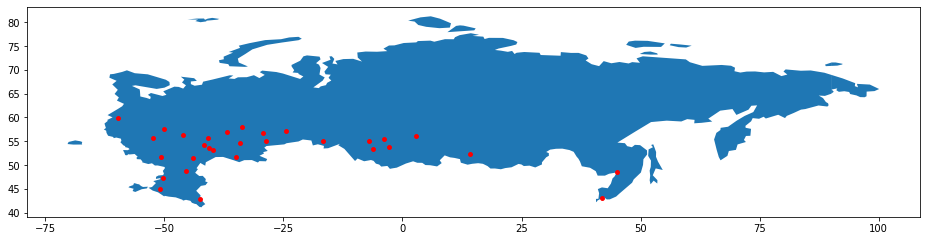

In [67]:
dataset = 'city.csv'
city_dataset = pd.read_csv(dataset)

top = city_dataset.sort_values(by=['population'], ascending=False)[:30][['address', 'geo_lat', 'geo_lon']]

cities_gdf = get_cities_geodataframe(top)

cities = loader(cities_gdf)

russia_gdf = russia()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
russia_gdf.plot(ax=ax)
cities_gdf.plot(ax=ax, marker='o', color='red', markersize=15)

In [68]:
good_city_order, total_distance, temps, dists = optimal_state(
      cities,
      energy_fn=path_length,
      neighbour_fn=new_state,
      ax=ax
    )


Temperature: 1000.000 Distance: 65368.527
Temperature: 990.000 Distance: 62265.064
Temperature: 980.100 Distance: 60302.828
Temperature: 970.299 Distance: 60359.340
Temperature: 960.596 Distance: 57529.565
Temperature: 950.990 Distance: 58200.267
Temperature: 941.480 Distance: 58058.196
Temperature: 932.065 Distance: 57500.338
Temperature: 922.745 Distance: 59216.867
Temperature: 913.517 Distance: 59101.388
Temperature: 904.382 Distance: 55220.529
Temperature: 895.338 Distance: 54723.012
Temperature: 886.385 Distance: 51427.914
Temperature: 877.521 Distance: 50823.724
Temperature: 868.746 Distance: 50798.039
Temperature: 860.058 Distance: 50798.039
Temperature: 851.458 Distance: 46794.138
Temperature: 842.943 Distance: 47924.392
Temperature: 834.514 Distance: 47252.973
Temperature: 826.169 Distance: 46959.896
Temperature: 817.907 Distance: 45895.031
Temperature: 809.728 Distance: 45895.031
Temperature: 801.631 Distance: 46604.120
Temperature: 793.614 Distance: 46604.120
Temperature: 78

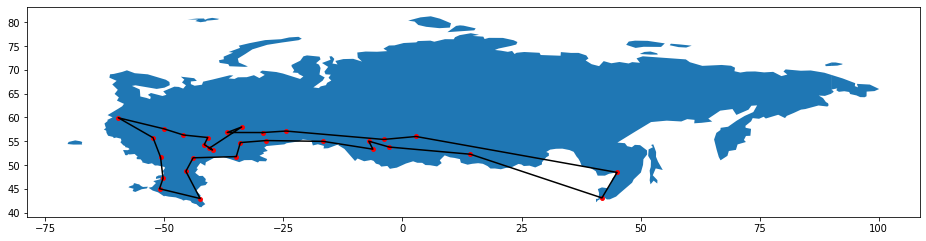

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
russia_gdf.plot(ax=ax)
cities_gdf.plot(ax=ax, marker='o', color='red', markersize=15)
ax.plot(*create_path(good_city_order).xy, color='black')
#ax.set_title(f'Total distance: {total_distance:7.3f}')
plt.savefig('map.png')

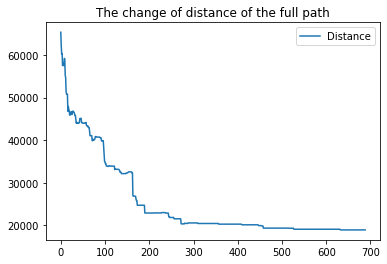

In [70]:
initial_temperature = 1000
cooling_rate = 0.003
temps = np.array(temps)
dists = np.array(dists)
plt.title(f'The change of distance of the full path')
#plt.title(f'Initial temperature: {initial_temperature} Cooling rate: {cooling_rate}')
#plt.plot(temps / temps.max(), label='Normalized temperature')
plt.plot(dists, label='Distance')
plt.legend()
plt.show()

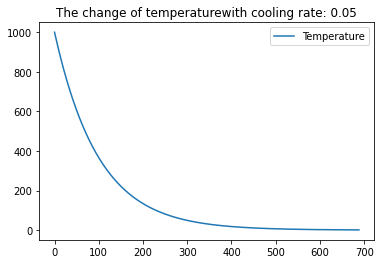

In [71]:
initial_temperature = 1000
cooling_rate = 0.05
temps = np.array(temps)
dists = np.array(dists)
plt.title(f'The change of temperaturewith cooling rate: {cooling_rate}')
#plt.title(f'Initial temperature: {initial_temperature} Cooling rate: {cooling_rate}')
plt.plot(temps, label='Temperature')
#plt.plot(dists, label='Distance')
plt.legend()
plt.show()

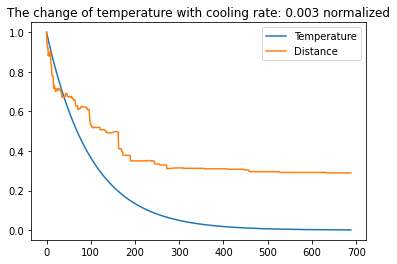

In [72]:
initial_temperature = 1000
cooling_rate = 0.003
temps = np.array(temps)
dists = np.array(dists)
plt.title(f'The change of temperature with cooling rate: {cooling_rate} normalized')
plt.plot(temps/ temps.max(), label='Temperature')
plt.plot(dists/ dists.max() , label='Distance')
plt.legend()
plt.show()

In [73]:
# while temp > 1:
#         current_energy = clac_energy(path)

#         iter_passed += 1
#         temperatures.append(temp)
#         energies.append(current_energy)

#         new_path, new_energy = neighbour_fn(path, clac_energy)
#         if new_energy < current_energy or random.uniform(0, 1) < math.exp((current_energy - new_energy) / temp):
#             path = new_path
#         temp *= 1 - cooling_rate


#         route = create_path(path)

#     temperatures.append(temp)
#     energies.append(current_energy)
#     return path, current_energy, temperatures, energies